In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [93]:
color_pal = sns.color_palette()

In [94]:
df = pd.read_csv("archive/PJME_hourly.csv")
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [95]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [96]:
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)

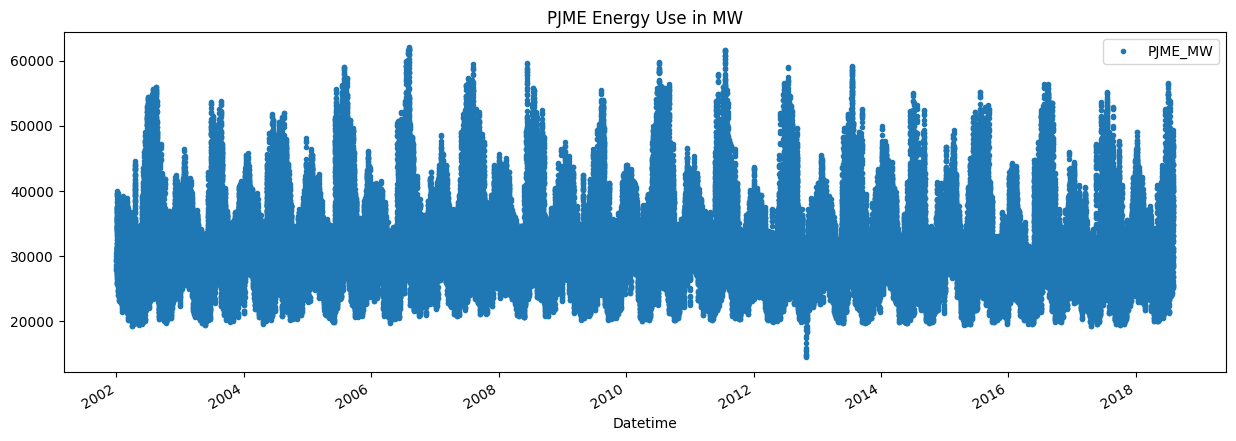

In [97]:
df.plot(style=".", figsize=(15, 5), color=color_pal[0],
        title="PJME Energy Use in MW")
plt.show()

#### TRAIN|TEST

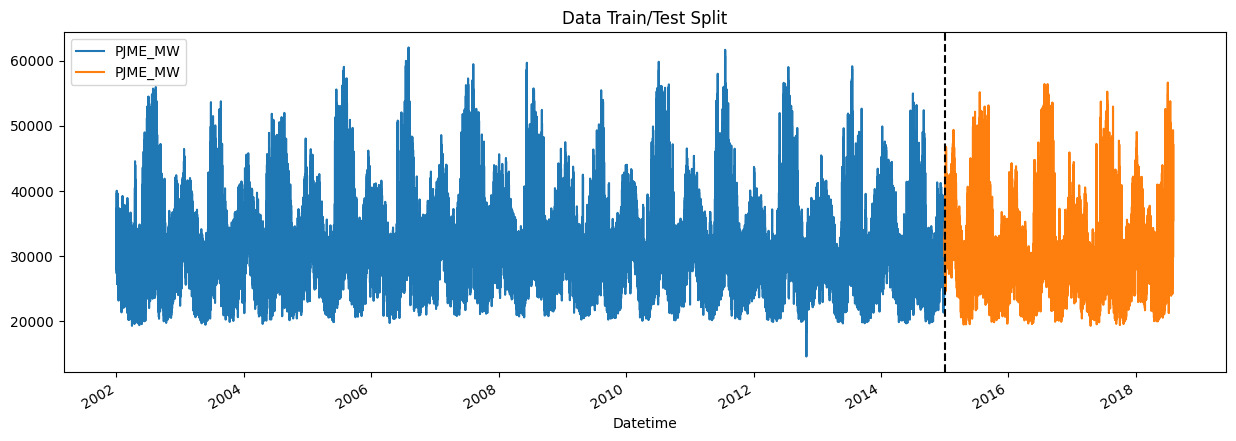

In [98]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Training Set", title="Data Train/Test Split")
test.plot(ax=ax, label="Test Set")
ax.axvline("01-01-2015", color="black", ls='--')
plt.show()

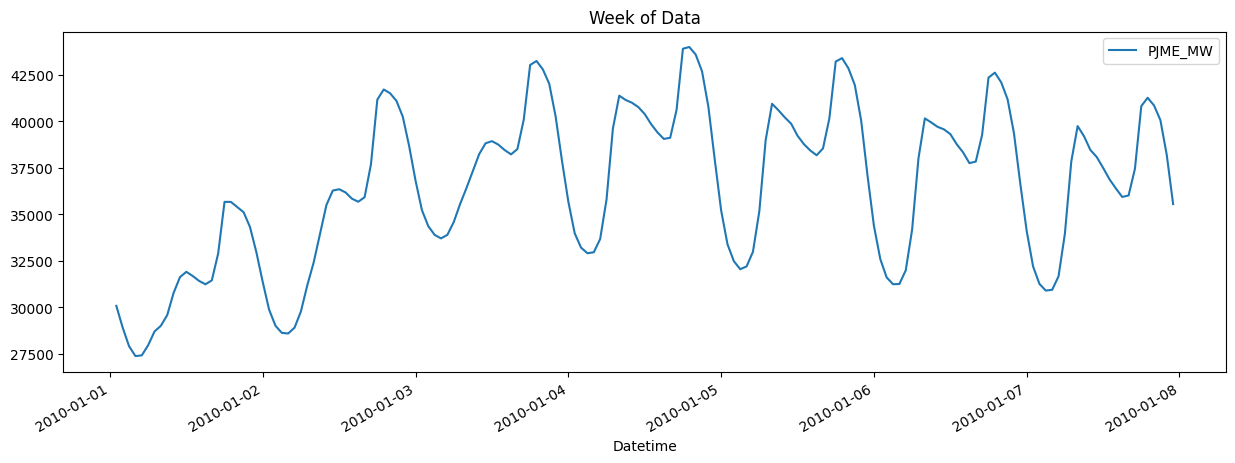

In [99]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(
    figsize=(15, 5), title="Week of Data"
)
plt.show()

## Feature Creation

In [100]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    return df

In [101]:
df = create_features(df)

### Visualize Feature|Target Relationship

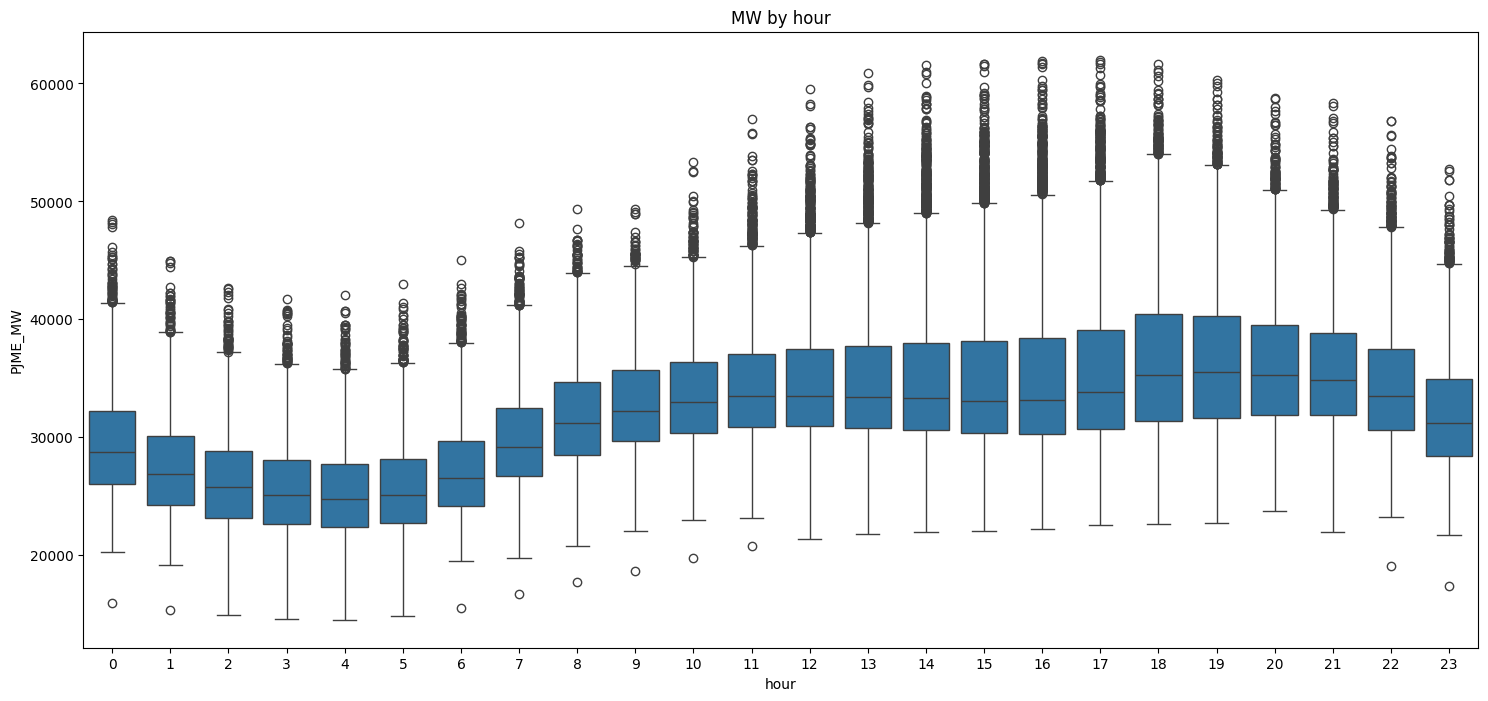

In [102]:
fig, ax = plt.subplots(figsize=(18, 8))
sns.boxplot(df, x='hour', y='PJME_MW')
ax.set_title("MW by hour")
plt.show()

/tmp/ipykernel_3584/1194975188.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x='month', y='PJME_MW', palette="Blues")


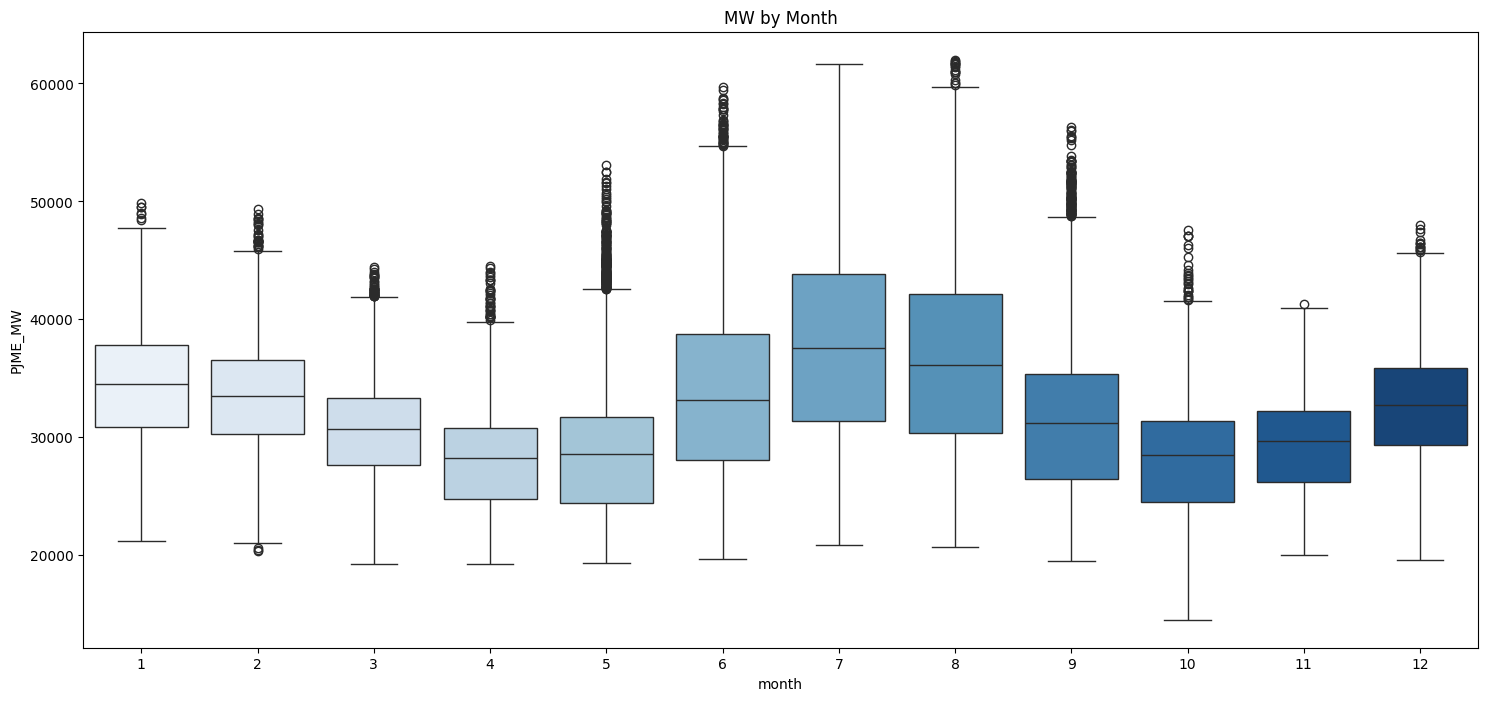

In [103]:
fig, ax = plt.subplots(figsize=(18, 8))
sns.boxplot(df, x='month', y='PJME_MW', palette="Blues")
ax.set_title("MW by Month")
plt.show()

In [104]:
df.columns

Index(['PJME_MW', 'hour', 'month', 'dayofweek', 'quarter', 'year',
       'dayofyear'],
      dtype='object')

Creat our Model

In [105]:
train = create_features(train)
test = create_features(test)

In [106]:
#Split dataset
X_train= train.drop('PJME_MW', axis=1)
y_train = train['PJME_MW']

X_test = test.drop('PJME_MW', axis=1)
y_test = test['PJME_MW']

In [107]:
train.head()

,PJME_MW,hour,month,dayofweek,quarter,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,12,1,4,2002,365
2002-12-31 02:00:00,25147.0,2,12,1,4,2002,365
2002-12-31 03:00:00,24574.0,3,12,1,4,2002,365
2002-12-31 04:00:00,24393.0,4,12,1,4,2002,365
2002-12-31 05:00:00,24860.0,5,12,1,4,2002,365


In [108]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619


[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[416]	validation_0-rmse:2804.52217	validation_1-rmse:3748.41719


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [109]:
f1 = pd.DataFrame(data=reg.feature_importances_,
             index = reg.feature_names_in_,
             columns=['importance'])

f1

,importance
hour,0.495674
month,0.179404
dayofweek,0.173109
quarter,0.000000
year,0.025457
dayofyear,0.126356


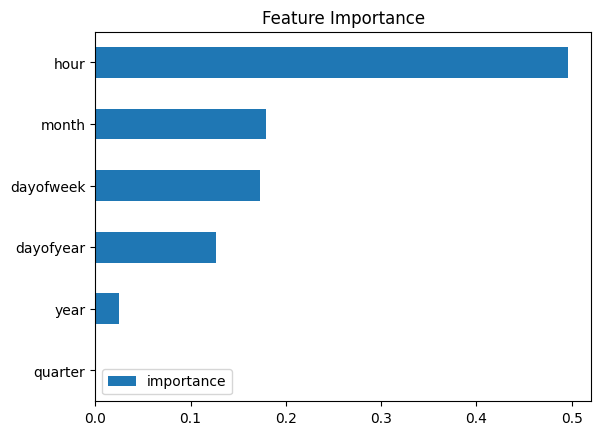

In [110]:
f1.sort_values("importance").plot(kind='barh', title='Feature Importance')
plt.show()

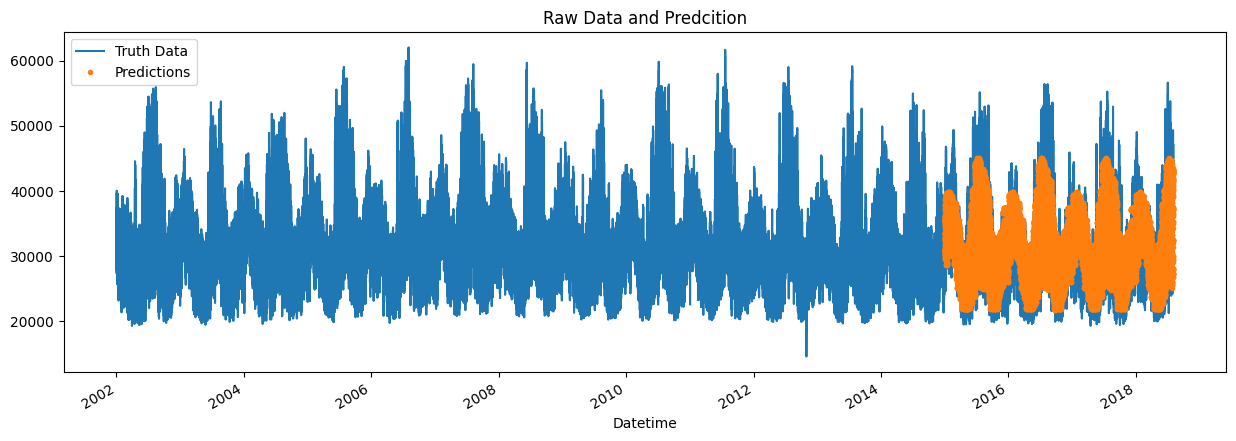

In [111]:
test['prediction'] = reg.predict(X_test)
new_df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = new_df[['PJME_MW']].plot(figsize=(15, 5))
new_df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title("Raw Data and Predcition")
plt.show()

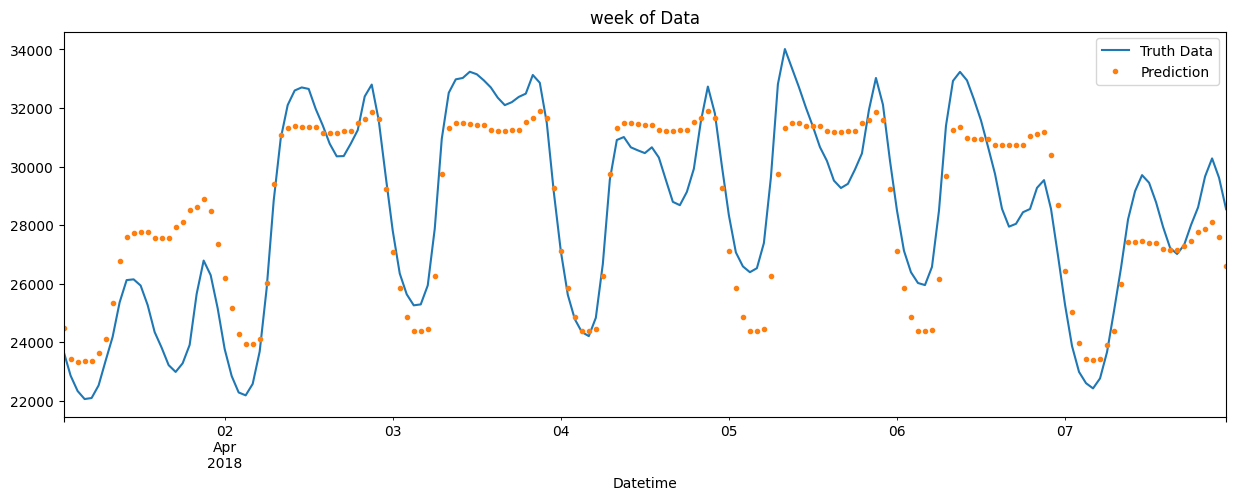

In [112]:
ax = new_df.loc[(new_df.index > '04-01-2018') & (new_df.index < '04-08-2018')]['PJME_MW'] \
     .plot(figsize=(15, 5), title="week of Data")
new_df.loc[(new_df.index > '04-01-2018') & (new_df.index < '04-08-2018')]['prediction'] \
     .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [113]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f"RMSE Score on Test set is: {score:0.2f}")

RMSE Score on Test set is: 3741.03


## Advanced Methods

> 1. Outlier Analysis and Removal

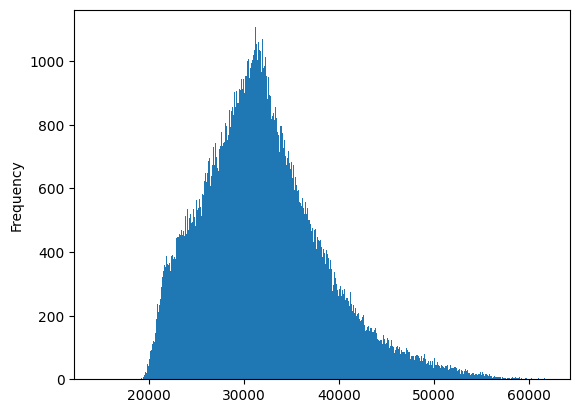

In [114]:
df['PJME_MW'].plot(kind='hist', bins=500);

<Axes: xlabel='Datetime'>

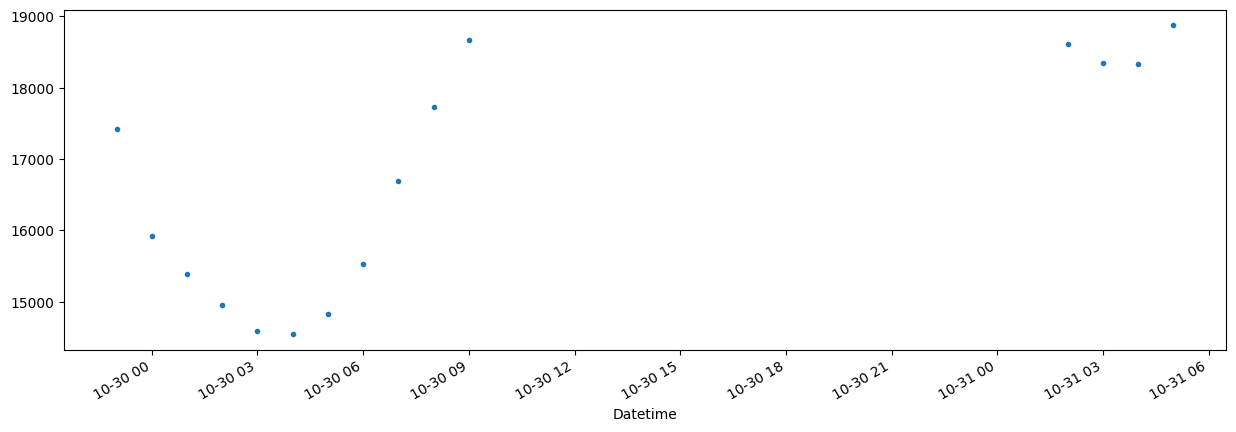

In [115]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(figsize=(15, 5), style='.')

In [116]:
df = df.query('PJME_MW > 19_000').copy()

> 2. Time Series Cross Validation

In [121]:
from sklearn.model_selection import TimeSeriesSplit


tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [122]:
df.shape

(145351, 7)

In [123]:
for train_idx, val_idx in tss.split(df):
    break


In [124]:
train_idx

array([     0,      1,      2, ..., 101524, 101525, 101526])

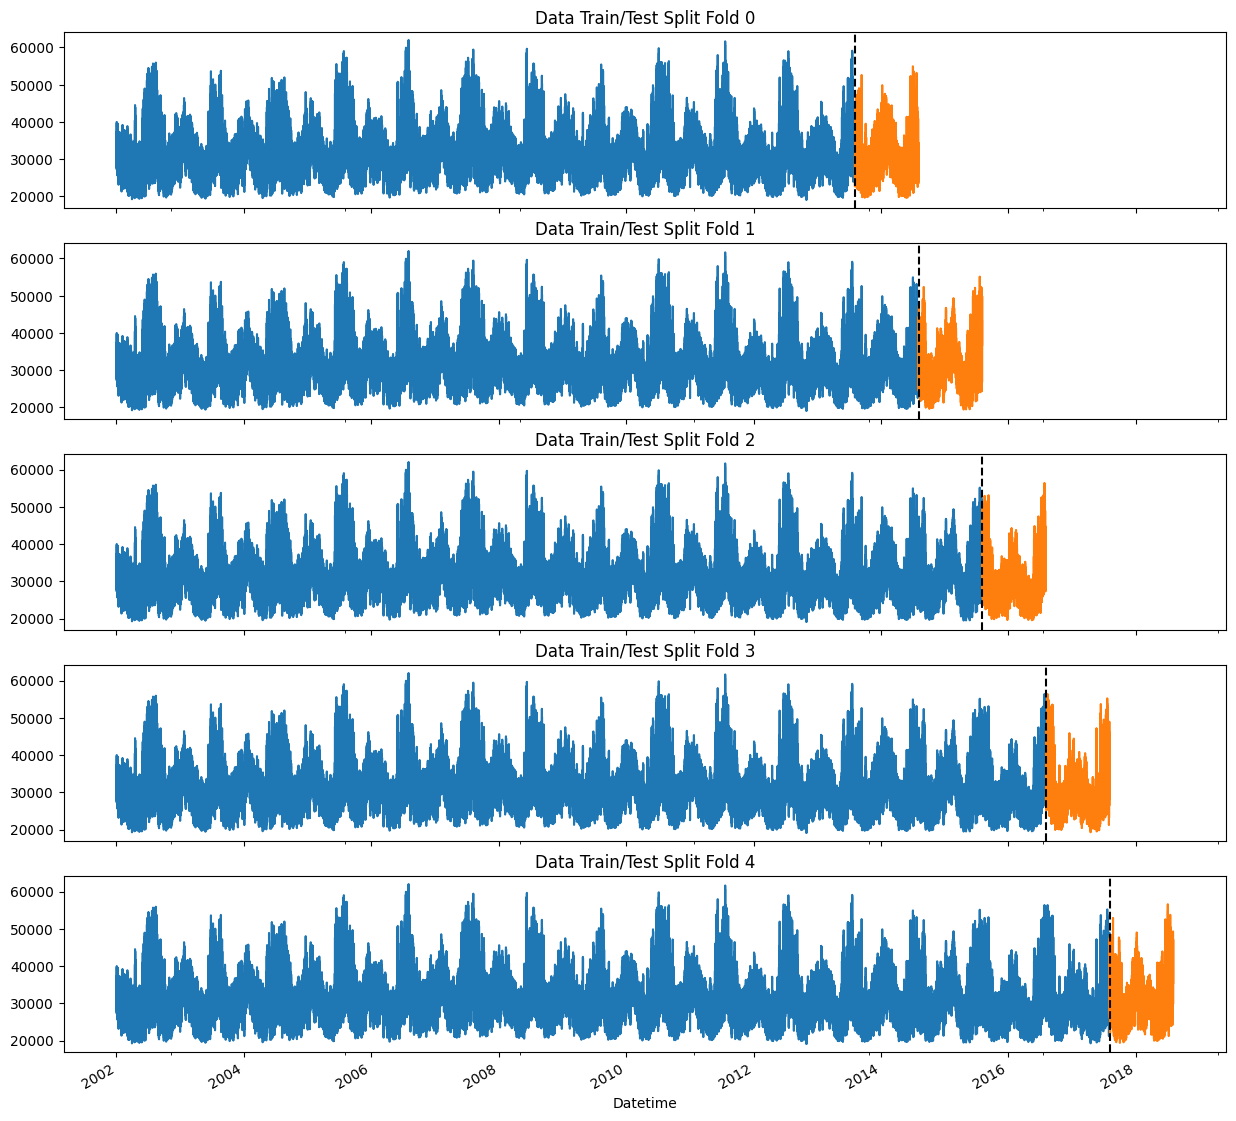

In [125]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()